# Clustering with Mixtures of Gaussians

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import slideUtilities as sl
import laUtilities as ut
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [7]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

## Soft Clustering

We have seen how to cluster objects using k-means: 

1. start with an initial set of cluster centers,
2. find the objects that are close to each center and 
3. create a new set of clusters and recompute the centers of the new groups. 
4. Repeat 2-3 until convergance.

Every object is assigned to a **single** group. 

This is called __hard__ assignment.

However, there may be cases were we either cannot use hard assignments or we do not want to do it! 

In particular, we may believe that the best description of the data is a set of __overlapping__ clusters.

Imagine that we believe society consists of two kinds of individuals: poor, or rich.

Let's think about how we might model society as a mixture of poor and rich, when viewed in terms of age.

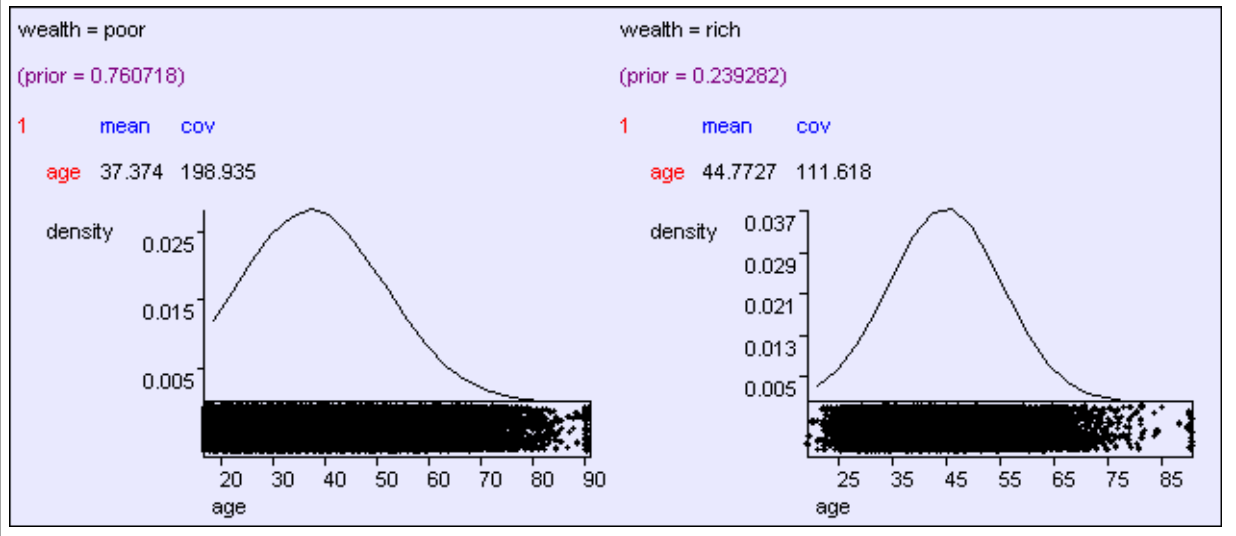

In [8]:
# image credit: http://autonlab.org/_media/tutorials/gmm14.pdf
sl.hide_code_in_slideshow()
display(Image("figs/L8-age-wealth-gaussians.png", width=550))

Clearly, viewed along the age dimension, there are two clusters that overlap.   


Furthermore, given some particular individual at a given age, say 25, we cannot say for sure which cluster they belong to.  

Rather, we will use _probability_ to capture our uncertainty about the cluster that any single individual belongs to.

Thus, we could say that a given individual ("John Smith", age 25) belongs to the _rich_ cluster with some probability, and the _poor_ cluster with some different probability.

Naturally we expect the probabilities to sum up to 1.

This is called __soft assignment,__ and a clustering using this principle is called __soft clustering.__

More formally, we say that an object can belong to each particular cluster with some probability, such that the sum of the probabilities adds up to 1 for each object. 

For example, assuming that we have two clusters $C_1$ and $C_2$, we can have that an object $x_1$ belongs to $C_1$ with probability $0.3$ and to $C_2$ with probability $0.7$.

## Mixtures of Gaussians

We're going to consider a particular model for each cluster: the Gaussian distribution.

$${\displaystyle f(x\;|\;\mu ,\sigma ^{2})={\frac {1}{\sqrt {2\sigma ^{2}\pi }}}\;exp({-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}})$$

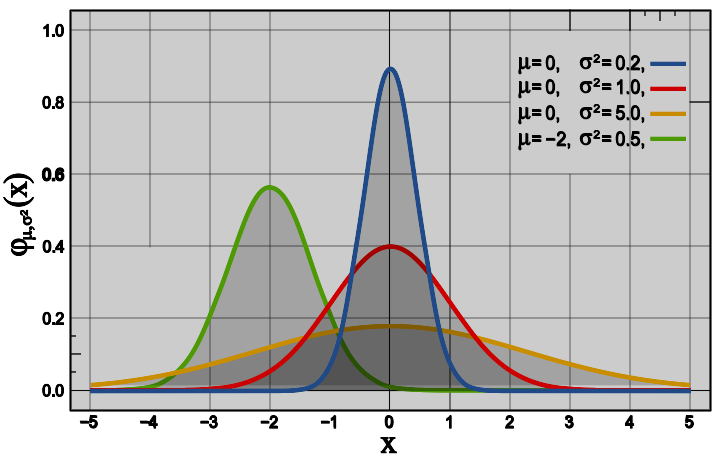

In [11]:
sl.hide_code_in_slideshow()
display(Image("figs/L8-Normal_Distribution_PDF.png", width=550))

By <a href="//commons.wikimedia.org/wiki/User:Inductiveload" title="User:Inductiveload">Inductiveload</a> - self-made, Mathematica, Inkscape, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=3817954">https://commons.wikimedia.org/w/index.php?curid=3817954</a>

You can see that, for example, this is a reasonable model for the distribution of ages in each of the two population groups (rich and poor).

In [ ]:
In the case of the population example, we have a single feature: age.   How do we use a Guassian

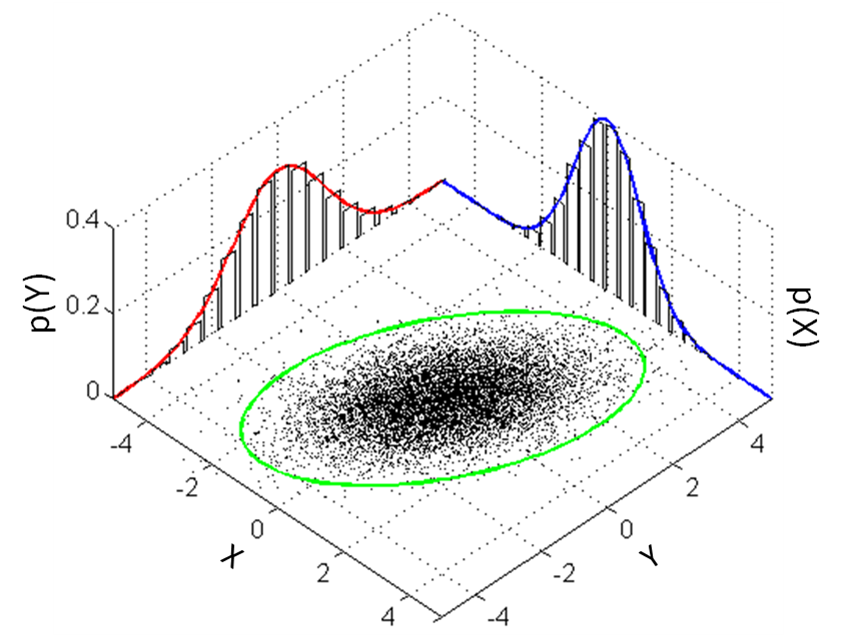

In [10]:
# image credit: http://autonlab.org/_media/tutorials/gmm14.pdf
sl.hide_code_in_slideshow()
display(Image("figs/MultivariateNormal.png", width=550))

By <a href="//commons.wikimedia.org/wiki/User:Bscan" title="User:Bscan">Bscan</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/publicdomain/zero/1.0/deed.en" title="Creative Commons Zero, Public Domain Dedication">CC0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=25235145">https://commons.wikimedia.org/w/index.php?curid=25235145</a>

$$
f_{{{\mathbf  x}}}(x_{1},\ldots ,x_{n})={\frac  {1}{{\sqrt  {(2\pi )^{{n}}|{\boldsymbol  \Sigma }|}}}}\exp \left(-{\frac  {1}{2}}({{\mathbf  x}}-{{\boldsymbol  \mu }})^{{\mathrm  {T}}}{{\boldsymbol  \Sigma }}^{{-1}}({{\mathbf  x}}-{{\boldsymbol  \mu }})\right)$$

Expectation Maximization (**EM**) can help with that!!

Assume that we have n points $x_1, x_2,\ldots,x_n$ in  a $d$ dimensional space.  Assume that we have k clusters in the data (or we have k different processes-models that generate the data.)


What we want is to compute the final $k$ clusters. 
<br>
However, to do that, it would be great if we can find a way to assign each point to each cluster with some probability (notice that these are hidden values!!! that are very important). We have two sets of uknown parameters: the set of hidden values (probabilities) and the set of cluster parameters (center and variance for example).

**EM** works as follows:

*Initialization*: start with an initial set of cluster  $C_1^1, C_2^1, \ldots, C_k^1$ and inital probability
    that a random point belongs to each cluster $P(C_1), P(C_2), \ldots, P(C_k)$

*Step 1* (Expectation): Compute the probability (weight)  that a given point $x_i$ belongs to cluster $C_j$
    $$ P(C_j|x_i)=\frac{P(x_i|C_j)}{P(x_i)}P(C_j)$$

Also note that:           $P(x_i) = \sum_{j=1}^k P(x_i|C_j)P(C_j)$

This is also  the posterior probability of $C_j$ given $x_i$.

*Step 2 (Maximization)*: Using the weights computed in the previous step, recompute the clusters and cluster probabilities using maximum likelihod (parameters $\theta$)!!.

$$P(C_j) = \frac{1}{n}\sum_{i=1}^n P(C_j|x_i)$$

Now, compute new values for the clusters $C_1, C_2, \ldots, C_n$ using MLE!

Repeat Steps 1 and 2 until stabilization.

If we model each cluster as a multi-dimensional Gaussian, then we can instatiate every part of
the algorithm. This is the GMM (Gaussian Mixture Model) algorithm implemented in *sklearn.mixture* module.

In that case $C_i$ is represented by $(\mu_i, \Sigma_i)$ and
$$ P(x_i|C_j) = \frac{1}{\sqrt{(2\pi)^d |\Sigma_j|}} exp (-\frac{1}{2}(x_i-\mu_j)^T\Sigma_j^{-1}(x_i-\mu_j))$$

In the Step 2, we estimate the parameters of the Gaussian using MLE:
$$\mu_j'=\frac{\sum_{i=1}^n P(C_j|x_i) x_i}{\sum_{i=1}^n P(C_j|x_i)}$$

and

$$\Sigma_j = \frac{\sum_{i=1}^n P(C_j|x_i) (x_i-\mu_j')(x_i-\mu_j')^T}{\sum_{i=1}^n P(C_j|x_i)}$$

Example using **GMM**

0.0213050842285


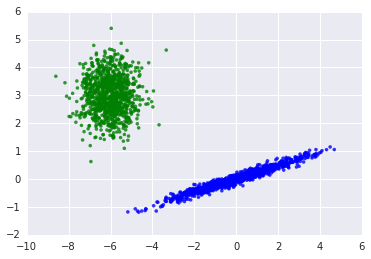

In [21]:
import time
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

import seaborn as sns
%matplotlib inline


# Number of samples per component
n_samples = 1000

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a mixture of Gaussians with EM using two components
gmm = mixture.GMM(n_components=2, covariance_type='diag')

t0 = time.time()

gmm.fit(X)

t1 = time.time()

print t1-t0

y_pred = gmm.predict(X)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)
plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10, alpha=0.8)

